<br/>

$$ \huge{\underline{\textbf{ Model Free Control - Off Policy }}} $$

$$ \Large{\textbf{ Part 2: Expectation Based Methods }} $$


# Contents

* Intro
  * [Sources](#Sources)
  * [Introduction](#Introduction)
  * [Imports](#1D-Corridor) - import stuff from [part 1](../Lecture05/ModelFreeControl_Part1.html)
  * [SARSA - Refresher](#SARSA---Refresher) - refresher from [part 1](../Lecture05/ModelFreeControl_Part1.html#SARSA)

* Expectation Based Methods
  * [Q-Learning](#Q-Learning)
  * [Expected SARSA](#Expected-SARSA) - off-policy version of standard SARSA using expectations
  * [Tree Backup](#Tree-Backup) - multi-step Expected SARSA

# Sources

* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 5 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf
  * Lecture 5 vid: https://www.youtube.com/watch?v=0g4j2k_Ggc4
* Sutton and Barto 2018: http://incompleteideas.net/book/the-book-2nd.html

# Introduction

This post roughly corresponds to part 2 of Lecture 5 of UCL RL course by David Silver.

We will explore off-policy algorithms, as per vidoes like famous Q-Learning and Off-Policy MC. But we will also add more general versions that were excluded from videos, but I think will help understand whole picture. In addition we will look into Expected SARSA and Tree Backup algorithms.

As terminology can be a bit confusing, let's have a quick look at our little zoo of RL algorithms

<img src="assets/alg_zoo.png"/>
<center>Table: Numbers in bracket refer to chapters in Sutton and Barto 2018</center>
<center>Implementations in this notebook do not exactly correspond to the book</center>

<br/>

To better explain differences between On-Policy, Expectation and Importance Sampling, let's consider a mini-MDP below
<img src="assets/mini-mdp.png"/>
* agent starts in state START, then automatically picks action _forward_ (no choice here)
* after going forward, agent finds a gold coin (+1 reward) and ends up in a state ROOM
* from the ROOM, agent can go either _left_ or _right_ with probability determined by policy under consideration
* if agent goes _left_, then it ends up finding SMALL TREASURE (+10 reward), MDP terminates
* if agent goes _right_, then it finds LARGE TREASURE (+100 reward), MDP terminates
* mini-MDP is fully deterministic

Let's consider state-action values in reverse order:
* Assume all Q-values are initialised to zero
* Assume no discounting
* $Q(ROOM,left)$ or $Q(R,l)$ - as long as it is being explored, it will evaluate to corect value +10, and it doesn't depend on policy, this isn't very interesting
* $Q(ROOM,right)$ or $Q(R,r)$ - same as above
* $Q(START,forward)$ or $Q(S,f)$ - this one we are interested in. It very much depends on policy being executed, for example for random policy

$$ Q(S,f) = 1 + .5*Q(R,l) + .5*Q(R,r) = 1 + 5 + 50 = 56 $$

For each algorithm we will show different ways we can backup

$$ Q(S,f) \leftarrow Q(R,l), Q(R,r) $$

But first let's get some setup code out of the way

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Environment is exactly the same as in [previous post](ModelFreeControl_Part1.html)
<img src="assets/corridor2.png"/>

In [2]:
from ModelFreeControl_Part1 import LinearEnv, REF_RANDOM, REF_GREEDY

Let's create environment and policies for future use

In [3]:
env = LinearEnv()

st_shape = [11]         # state space shape
st_act_shape = [11, 2]  # state-action shape
pi_random = np.tile([0.50, 0.50], [11, 1])  # starting random policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # optimal greedy policy
pi_skewed = np.tile([0.40, 0.60], [11, 1])  # will use this later

And import common functions, they are also exactly the same as in [previous post](ModelFreeControl_Part1.html)

In [4]:
from ModelFreeControl_Part1 import generate_episode, LogEntry, plot_experiments

# SARSA - Refresher

Puropose of this section is to show how good old SARSA works on our mini-MDP. Show problems with on-policy exploration, and then in subsequnet sections we will show how Q-Learning, Expected SARSA and Importance Sampling solve these problems.

Code for SARSA was introduced in [previous post](ModelFreeControl_Part1.html). I repeat it here for convinience. We will treat SARSA, N-Step SARSA and MC Control as together. The main difference between them is backup length. Other than that, the underlying principle is the same:
1. update Q-value estimation
2. update policy towards $\epsilon$-greedy

SARSA update formula

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) }\color{black}{} - Q(S_t,A_t) \big] $$

How does SARSA update $Q(S,f)$? By repeated sampling, for example for random policy sometimes we backup from $Q(R,l)$, sometimes from $Q(R,r)$. Becouse we update only a little bit (this is by $\alpha$) towards each target every time, value eventually settles on weighted average between $Q(R,l)$ and $Q(R,r)$ plus reward +1.

That is all nice and rosy as long as actually keep visiting all states. If policy is greedy, and it locks itself into always choosing left action before properly evauating $Q(R,r)$ then agent is doomed, it will never discover big treasure.

This demonstrates the main problem with on-policy methods. We have to use $\epsilon$-greedy policy to guarantee continous exploration. But when we use $\epsilon$-greedy agent will not achieve optimal performance. We could decay $\epsilon$ with time, but that brings practical issues with estabilishing correct schedule.

Let's import SARSA code from previous post and repeat the experiment.

In [5]:
# from ModelFreeControl_Part1 import make_eps_greedy, mc_control, sarsa

In [6]:
def make_eps_greedy(Q, policy, eps):
    policy = np.zeros(shape=st_act_shape) + eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps
    return policy

In [7]:
def sarsa(env, policy, N, alpha, eps):
    hist, perf = [], []
    Q = np.zeros(shape=st_act_shape)
    for ep in range(N):
        trajectory = generate_episode(env, policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0 * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        
        policy = make_eps_greedy(Q, policy, eps)  # Make policy e-greedy

        hist.append(Q.copy())
        perf.append(len(trajectory)-1)
    return np.array(hist), np.array(perf)

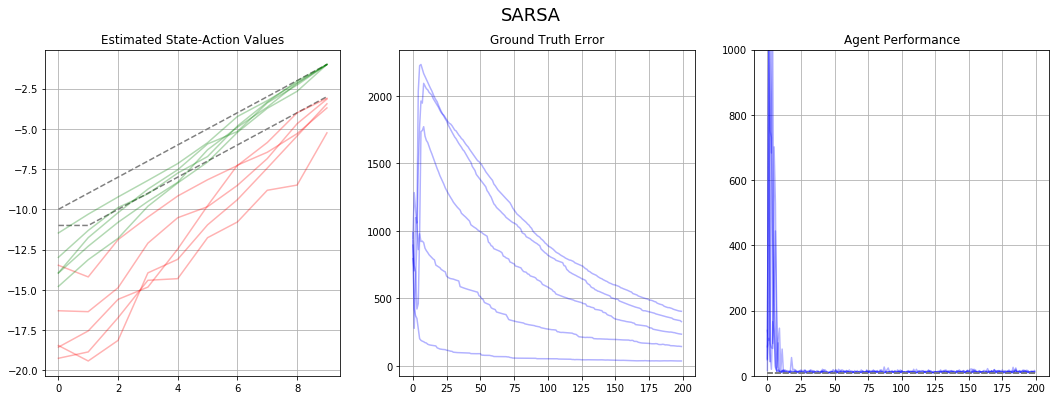

In [8]:
log = []
for _ in range(5):
    hist, perf = sarsa(env, pi_random, N=200, alpha=0.1, eps=0.1)
    log.append(LogEntry('sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'SARSA')

### Note on Exploring Starts

We could guarantee continous exploration by starting episode at random state and with random first action every time and then following given policy. This would guarantee all state-action pairs are evaluated, and subsequently fix the problem we encoutered above. After whole MDP is correctly evaulated we can switch off exploring starts and operate as normal in now solved MDP. This works disregarding if policy is greedy or not.

Problem with this is that it only works in small state spaces and usually can't be applied in real-world scenarios (how do you teleport robot into random initial states?).

# Q-Learning

Bring back mini-MDP

<img src="assets/mini-mdp.png"/>

Imagine yourself you are a wizard on a journey to find treasure. Tomorrow you will be allowed to enter mini-MDP for exactly one attempt to collect as much gold as possible. There will be no repeats. But being clever and powerful wizard, you figured out you can enter mini-MDP today in a ghost form, you won't be able collect gold today, but you can explore mini-MDP and prepare youself for tomorrow. Actually you can enter it in a ghost form as many times as you want.

You want to make sure you explore all possible routes, so you follow random policy. But you are interested in maximum possible gold you can gather. So every time you visit a state-action pair you write down _maximum possible gold_ you can collect from there onwards. After couple trials you note down values for $Q(R,l)$ and $Q(R,r)$ to be +10 and +100 respectively. Now you wonder what is _max_ possible gold from $Q(S,f)$? Well, that is +1 gold coin, and then +100, because obviously on the actuall trial tomorrow you will pick righ door. So your backup looks like this

$$ Q(S,f) \leftarrow Q(S,f) + \alpha \big[ \color{blue}{R + \gamma \max[Q(R,l), Q(R,r)]} \color{black}{} - Q(S,f) \big] $$

Or more generally

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma \max\limits_{a' \in A} Q(S_{t+1},a') }\color{black}{} - Q(S_t,A_t) \big] $$

Taa daa, and this is famous Q-Learning. Note that even if you had more choices form _START_ state, then you know you can always get +101 reward by following action _forward_. Mini-MDP could be deeper, have more branches etc. same rules apply. If mini-MDP was nondeterministic, then you need to sample multiple times per action-value to properly estimate reward and environment dynamics, but other than that everything stays the same.

Let's modify SARSA as follows:
* introduce behavioural policy along target policy
* remove eps parameter
* roll two trajectories from each episode:
  * one as before
  * one to evaluate target policy, so we can plot agent progress
* modify _target_ line with new update rule
* update target policy always towards greedy
* evaluate performance based on target policy

In [9]:
def q_learning(env, pol_beh, pol_tar, N, alpha):
    hist, perf = [], []
    Q = np.zeros(shape=st_act_shape)
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Rt_1 + 1.0 * Q[St_1, At_1]  # SARSA
            target = Rt_1 + 1.0 * np.max(Q[St_1,:])  # Q-Learning
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        
        pol_tar = make_eps_greedy(Q, pol_tar, eps=0.0)  # eps always 0.0 to make policy greedy

        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

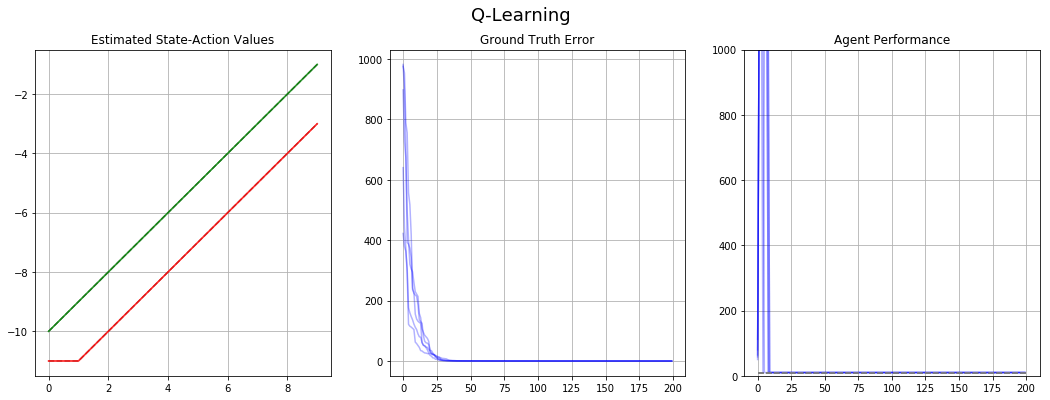

In [10]:
log = []
for _ in range(5):
    hist, perf = q_learning(env, pi_random, pi_random, N=200, alpha=0.1)
    log.append(LogEntry('q_learning', hist, perf))
plot_experiments(log, REF_GREEDY, 'Q-Learning')

Woo, perfect performance.

In example above we keep behavioural policy random through whole learning process. Nothing stops us from improving behavioural policy as well. We could, for example follow $\epsilon$-greedy policy as behavioural - keep improving it towards "good" choices, but still allow for exploration. Actually, in most case we would not have explicit "policy" table, we would pick actions on the fly according to current Q-Values. 

# Expected SARSA

<img src="assets/mini-mdp.png"/>

Let's assume we are performing SARSA updates while following random policy. Let's also assume $Q(R,l)$ and $Q(R,r)$ have been correctly evaluated already. There is alternative way to backup $Q(S,f)$ from $Q(R,l)$ and $Q(R,r)$. Namely we know what policy we are following. We know we will pick $Q(R,l)$ 50% of a time and $Q(R,r)$ 50% of a time. Then why not backup towards weighted average stright away?

$$ Q(S,f) \leftarrow Q(S,f) + \alpha \big[ \color{blue}{R + \gamma\pi(l|R)Q(R,l)+\gamma\pi(r|R)Q(R,r)} \color{black}{} - Q(S,A) \big] $$

Or more generally

$$ Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big[ \color{blue}{R_{t+1} + \gamma \sum_{a' \in A} \pi(a'|S_{t+1})Q(S_{t+1},a') }\color{black}{} - Q(S_t,A_t) \big] $$

Of course we still need to sample to learn about rewards at each time-step.

Now what if we want to follow one policy, and evaluate another one?

Going back to wizard example, let's assume different task, let's say oracle asks you to evaluate random policy, but you can always only follow skewed policy 40%/60% left/right (oracle knows if you cheat). You figure as follows:
* $Q(R,l)$ and $Q(R,r)$ will evaluate correctly to +10 and +100 no matter what is behavioural and target policy (as long as you keep visiting them)
* as per $Q(S,f)$, you know that under _target_ policy, you will visit $Q(R,l)$ 50% of a time and $Q(R,r)$ 50% of time, so you can do backup as per equations above, just plug in _target_ policy and you get correct $Q(S,f)$ for _target_ policy. Actually behavioural policy doesn't matter, as long as it keeps visiting $Q(S,f)$
* above hold true no matter how many levels deep you go, or even if MDP is loopy

Let's write some code, changes from q_learning are as follows:
* introduce _learn_ param, so we can disable policy improvement for now
* change _target_ line with new update equation

In [11]:
def exp_sarsa(env, pol_beh, pol_tar, N, alpha, learn=True):
    hist, perf = [], []
    Q = np.zeros(shape=st_act_shape)
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Rt_1 + 1.0 * Q[St_1, At_1]  # SARSA
            # target = Rt_1 + 1.0 * (pol_tar[St_1, 0]*Q[St_1, 0] + pol_tar[St_1, 1]*Q[St_1, 1])  # exp sarsa
            target = Rt_1 + 1.0 * np.sum(pol_tar[St_1,:] * Q[St_1,:]) # exp sarsa, equivalent to above
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        if learn:  # set eps to None to disable improvement step
            pol_tar = make_eps_greedy(Q, pol_tar, 0.0)  # eps 0.0 makes policy greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

### Off-Policy Prediction

Skewed behavioural policy, as per oracle task.

In [12]:
pi_skewed = np.tile([0.40, 0.60], [11, 1])  # go right a bit more often

And evaluate _random_ policy while following _skewed_ policy. With Expected SARSA we can set alpha to much higher value. Actually, because our MDP is fully deterministic, we can safely set it all the way to 1.0.

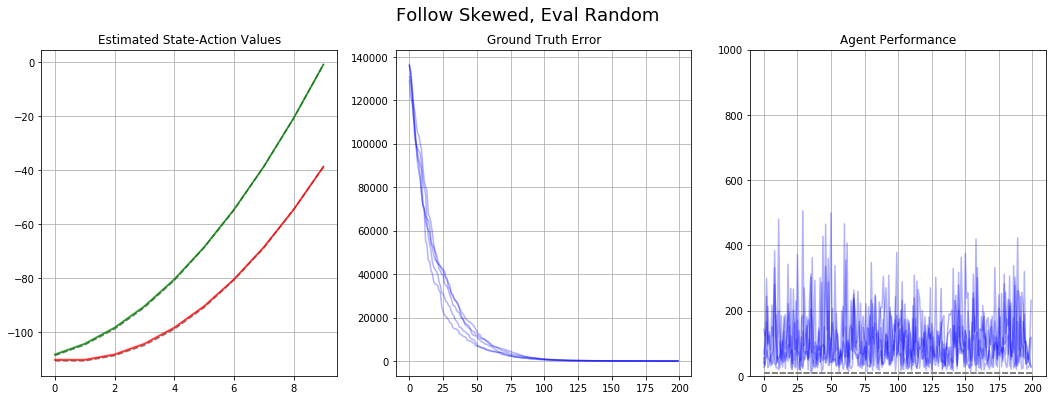

In [13]:
log = []
for _ in range(5):
    hist, perf = exp_sarsa(env, pi_skewed, pi_random, N=200, alpha=1.0, learn=False)
    log.append(LogEntry('follow-skew-eval-rand', hist, perf))
plot_experiments(log, REF_RANDOM, 'Follow Skewed, Eval Random')

Notice low variance. Even thoug we are following skewed policy, expectation based backups converge much quicker than equivalent sample based backups. Compare this with TD Prediction [from previous part](ModelFreeControl_Part1.html#TD-Prediction)

### Off-Policy Control

Enable learning. With greedy target policy (_eps_ internally set to zero) this is equivalent to Q-Learning

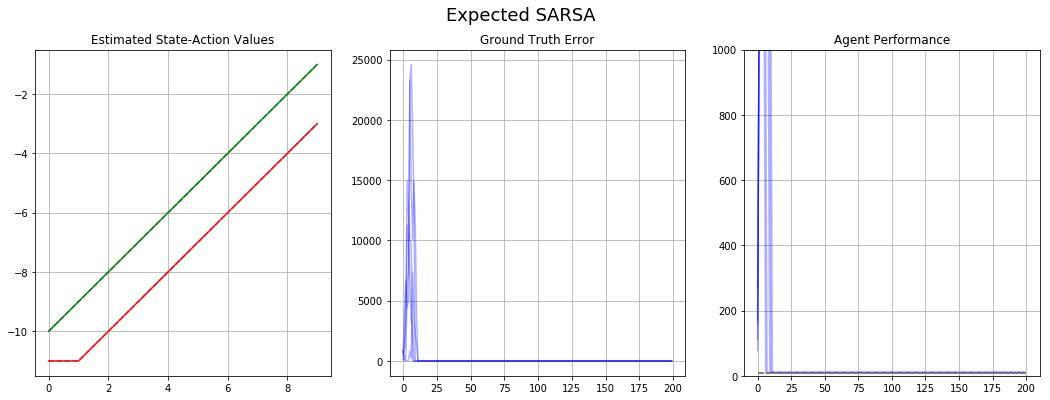

In [14]:
log = []
for _ in range(5):
    hist, perf = exp_sarsa(env, pi_random, pi_random, N=200, alpha=1.0, learn=True)
    log.append(LogEntry('exp-sarsa', hist, perf))
plot_experiments(log, REF_GREEDY, 'Expected SARSA')

# Tree Backup

There are two n-step extensions to Expected SARSA: N-Step Expected SARSA (on-policy) and Tree Backup (off-policy). In Tree Backup we use expectation at every time step. You can use fixed number of steps (e.g. nstep=5) or follow full trajectory (nstep=inf).

For details, see Sutton and Barto (2018), chapter 7.5 "Off-policy Learning Without Importance Sampling:
The n-step Tree Backup Algorithm". Note that this is _not_ exact replica of algorithm in the book. Most important differences:
 * this version only works with discount 1.0
 * this version is _offline_, book version is _online_

In [15]:
def tree_backup(env, pol_beh, pol_tar, N, alpha, nstep=float('inf'), learn=True, init_Q=None):
    hist, perf = [], []
    Q = np.zeros(shape=st_act_shape)
    if init_Q is not None: Q = init_Q.copy()
    for ep in range(N):
        trajectory = generate_episode(env, pol_beh)
        trajectory_2 = generate_episode(env, pol_tar)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            
            disc = 1.0              # discount, tested with disc==1.0 only!
            T = len(trajectory)-1   # terminal state
            max_j = min(t+nstep, T) # last state iterated, inclusive
            tmp_disc = 1.0          # this will decay
            pol_mult = 1.0
            target = 0
            
            # Iterate from t+1 to t+nstep or T (inclusive start and finish)
            for j in range(t+1, max_j+1):
                Sj, Rj, _, Aj = trajectory[j]
                if j != max_j:
                    # not-last-step, backup all Act != At
                    target += tmp_disc * pol_mult * (Rj + disc * (np.sum(pol_tar[Sj,:] * Q[Sj,:]) \
                                                                  - pol_tar[Sj,Aj] * Q[Sj,Aj]))
                else:
                    # last step, backup all
                    target += tmp_disc * pol_mult * (Rj + disc * np.sum(pol_tar[Sj,:] * Q[Sj,:]))
                tmp_disc *= disc
                pol_mult *= pol_tar[Sj, Aj]
                
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
            
        if learn:  # set eps to None to disable improvement step
            pol_tar = make_eps_greedy(Q, pol_tar, 0.0)  # eps 0.0 makes policy greedy
            
        hist.append(Q.copy())
        perf.append(len(trajectory_2)-1)
    return np.array(hist), np.array(perf)

### Off-Policy Prediction

Evaluate random policy while following skewed policy. With nstep set to "1" Tree Backup is equivalent to Expected Sarsa

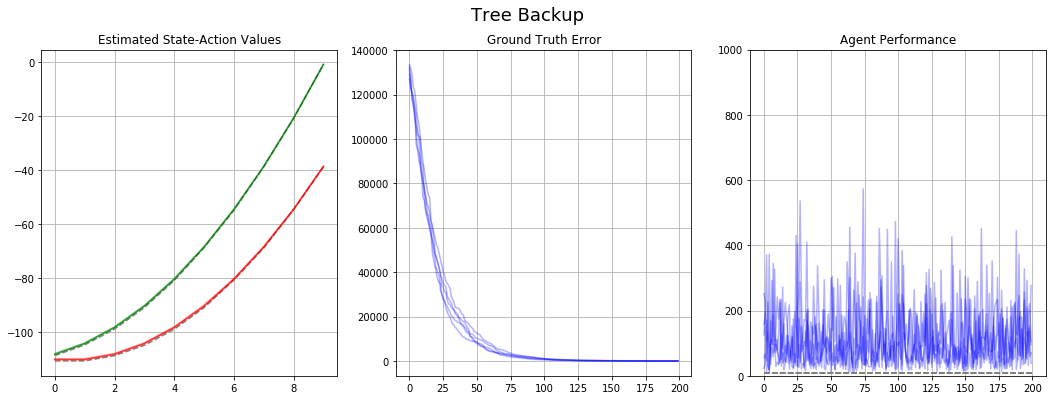

In [16]:
log = []
for _ in range(5):
    # hist, perf = tree_backup(env, pi_skewed, pi_random, N=200, alpha=1, nstep=1, learn=False)
    hist, perf = tree_backup(env, pi_skewed, pi_random, N=200, alpha=1, nstep=5, learn=False)
    log.append(LogEntry('tree-backup', hist, perf))
plot_experiments(log, REF_RANDOM, 'Tree Backup')

### Off-Policy Control

Improve target policy to be greedy. Perhaps we could call this N-Step Q-Learning?

Note that if target policy is greedy, then algorithm will backup steps up to a point where greedy policy diverges from actual steps taken.

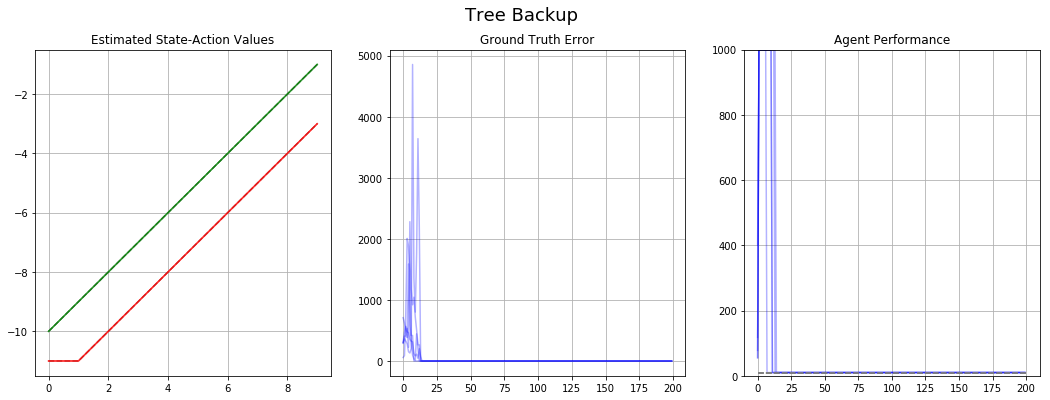

In [17]:
log = []
for _ in range(5):
    hist, perf = tree_backup(env, pi_skewed, pi_random, N=200, alpha=1, nstep=5, learn=True)
    log.append(LogEntry('tree-backup', hist, perf))
plot_experiments(log, REF_GREEDY, 'Tree Backup')